# Eddy statistics in-shore to the southern Agulhas Current

This notebook is a part of the Ocean Training Course 2023, Working Group 2. It's main goal is to count _events_ (eddy merging, eddy dipoles) occuring in the area studied and sampled during the cruise.  


### User options

In [1]:
# I/O options
obs_datadir = {'MY' : r'../../observations/SEALEVEL_GLO_PHY_L4_MY_008_047/sla/', 
               'NRT': r'../../observations/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/sla/'
              }

gos_datadir = r'../../datas/cmems/'
gos_product = {'MY': 'SEALEVEL_GLO_PHY_L4_MY_008_047', 
               'NRT': 'SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046'
              }

# Box definitions
box_south_agulhas = {'longitude': (26, 36), 'latitude': (-37, -32)}
box_semc          = {'longitude': (42.5, 47.5), 'latitude': (-28, -25)}

# Period of observations
time_period  = ('2003-01-01', '2022-12-31')

# logger type
logger_type = 'ERROR'   # (py-eddy-tracker) Available options: ERROR, WARNING, INFO, DEBUG

In [2]:
# Constants
earth_radius = 6371229.

### Import necessary modules

In [3]:
import glob
import json
import os
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.path import Path
from scipy.signal import argrelextrema
from shapely.geometry.polygon import LinearRing

from py_eddy_tracker import start_logger
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.poly import create_vertice
from py_eddy_tracker.tracking import Correspondances

start_logger().setLevel(logger_type)

### function definition

In [4]:
def to_datetime(days):
    """convert a number of days after 1950-01-01 to the equivalent datetime"""
    return datetime(1950, 1, 1) + days * timedelta(days=1)

def to_timeint(dt):
    """convert a datetime to an equivalent integer (days after 1950-01-01)"""
    return (dt-datetime(1950,1,1)).days

def get_xcoord(lons, lats):
    """compute x coordinates in earth coordinates system."""
    rad_lons = np.pi*lons/180
    rad_lats = np.pi*lats/180
    
    return earth_radius * np.sin(rad_lats) * np.cos(rad_lons)

def get_ycoord(lons, lats):
    """compute y coordinates in earth coordinates system."""
    rad_lons = np.pi*lons/180
    rad_lats = np.pi*lats/180
    
    return earth_radius * np.sin(rad_lats) * np.sin(rad_lons)

def select_obsfiles(lfiles, period=(None, None)):
    """select files corresponding to observation contain in a specified period."""
    rlist = list()
    
    for f in lfiles:
        if 'Cyclonic' in f:
            y = f.split('Cyclonic_')[-1][:4]
            m = f.split('Cyclonic_')[-1][4:6]
            d = f.split('Cyclonic_')[-1][6:8]
        elif 'Anticyclonic' in f:
            y = f.split('Anticyclonic_')[-1][:4]
            m = f.split('Anticyclonic_')[-1][4:6]
            d = f.split('Anticyclonic_')[-1][6:8]
        else:
            pass
        
        conds = period[0] is None or np.datetime64(y+'-'+m+'-'+d) >= np.datetime64(period[0])
        conds = conds and (period[1] is None or np.datetime64(y+'-'+m+'-'+d) <= np.datetime64(period[1]))
        if conds:
            rlist.append(f)
    
    return rlist

def select_tracks_in_box(eddies, box, min_lifetime=7):
    """select observations which are in a given lon, lat box."""
    lon_min, lon_max = box['longitude']
    lat_min, lat_max = box['latitude']
    
    track_ids, track_cnts = np.unique(eddies.tracks, return_counts=True)

    indexes_sel = np.where(track_cnts >= min_lifetime)[0]
    tracked_sel = eddies.extract_ids(list(track_ids[indexes_sel]))

    conds = (tracked_sel.lon >= lon_min) & (tracked_sel.lon <= lon_max)
    conds = conds & (tracked_sel.lat >= lat_min) & (tracked_sel.lat <= lat_max)

    ids_res = np.unique(tracked_sel.tracks[np.where(conds)[0]])
    obs_res = eddies.extract_ids(list(ids_res))
    
    return obs_res


def select_tracks_by_time(eddies, t):
    """select all observations done at time `t`."""
    if isinstance(t, datetime):
        index = np.where(to_datetime(eddis.time) == t)[0]
    else:
        index = np.where(eddis.time == t)[0]
    
    


def linear_ring_from_box(box):
    """return a LinearRing polygon object from a given box to plot in maps"""
    lon_min, lon_max = box['longitude']
    lat_min, lat_max = box['latitude']
    
    return LinearRing([(lon_min, lat_min), 
                       (lon_max, lat_min), 
                       (lon_max, lat_max), 
                       (lon_min, lat_max)])



## South Eastern Agulhas Current (SEAC) - some eddy statistics

In [5]:
# First, select all the eddy observations in the selected period 
cycl_files = list()
acyc_files = list()

for ptype in obs_datadir:
    cycl_files += glob.glob(os.path.join(obs_datadir[ptype], 'Cyclonic_*'))
    acyc_files += glob.glob(os.path.join(obs_datadir[ptype], 'Anticyclonic_*'))
    
cycl_files = sorted(select_obsfiles(cycl_files, period=time_period))
acyc_files = sorted(select_obsfiles(acyc_files, period=time_period))

In [6]:
# First, select eddies track
c = Correspondances(datasets=sorted(cycl_files[:]), class_method=AreaTracker, virtual=3)
c.track()
c.prepare_merging()

a = Correspondances(datasets=sorted(acyc_files[:]), class_method=AreaTracker, virtual=3)
a.track()
a.prepare_merging()

# -- here, we get a collection of cyclonic eddies
c_eddies = c.merge(raw_data=False)
c_eddies.virtual[:] = c_eddies.time == 0
c_eddies.filled_by_interpolation(c_eddies.virtual == 1.)

# -- same for the anticyclonic eddies
a_eddies = a.merge(raw_data=False)
a_eddies.virtual[:] = a_eddies.time == 0
a_eddies.filled_by_interpolation(a_eddies.virtual == 1.)

In [7]:
# Load altimetry datasets
list_gos = list()
for ptype in gos_product:
    list_gos += glob.glob(os.path.join(gos_datadir, gos_product[ptype], '*.nc'))

# Load dataset and init grid object
ds       = xr.open_mfdataset(list_gos)
g        = RegularGridDataset(list_gos[0], "longitude", "latitude")

### South East Agulhas Current (SEAC) box

In [8]:
lon_min_seac, lon_max_seac = box_south_agulhas['longitude']
lat_min_seac, lat_max_seac = box_south_agulhas['latitude']

area_seac = dict(llcrnrlon=lon_min_seac, llcrnrlat=lat_min_seac, urcrnrlon=lon_max_seac, urcrnrlat=lat_max_seac)

c_obs_seac = c_eddies.extract_with_area(area_seac)
a_obs_seac = a_eddies.extract_with_area(area_seac)

Cyclonic eddies in the South East Agulhas Current (SEAC) region from 2003-01-01 to 2022-12-31
  > With lifetime >= 1 days: 2863 on 46313 observations
  > Mean amplitude = 0.141 
  > Mean radius    = 49.2 

Anticyclonic eddies in the South East Agulhas Current (SEAC) region from 2003-01-01 to 2022-12-31
  > With lifetime >= 1 days: 3596 on 43148 observations
  > Mean amplitude = 0.068 
  > Mean radius    = 49.6 



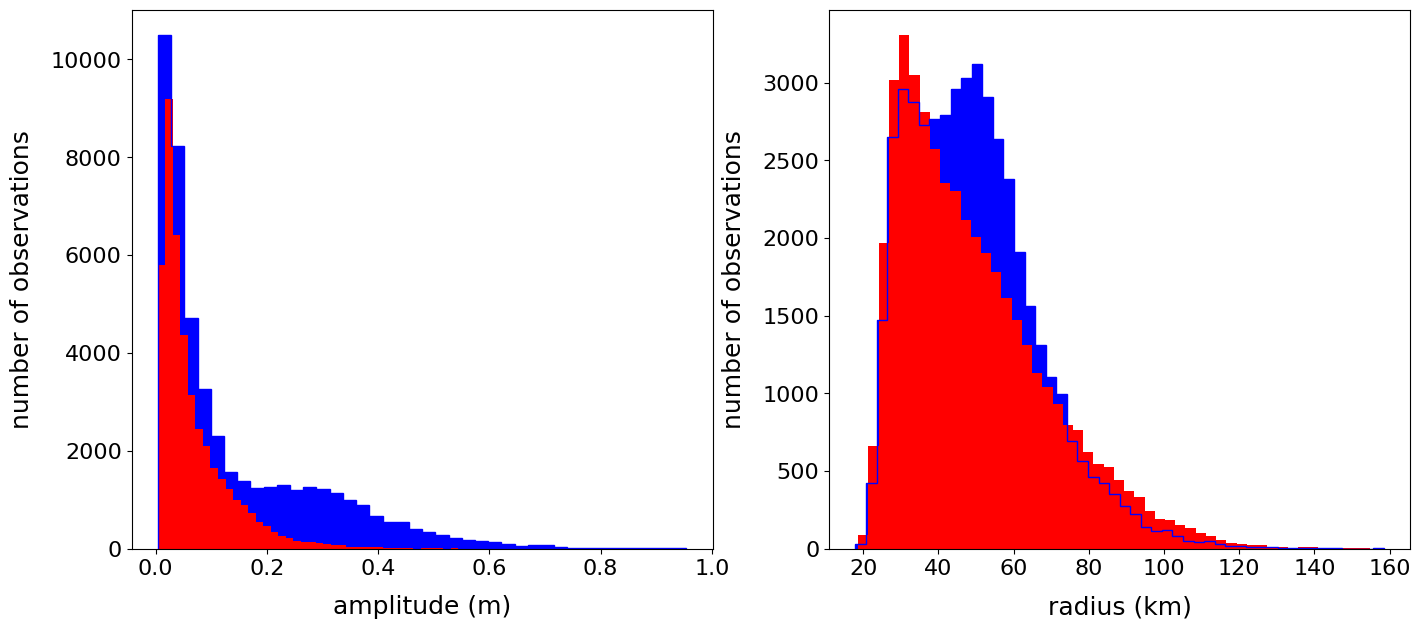

In [9]:
nbdays = 1

label_size = 18
tick_size  = 16

# Amplitude and radius histogram
fig = plt.figure(figsize=(16.5, 7))

# -- amplitude
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('amplitude (m)', size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of observations',  size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

a_ampl = select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).amplitude
c_ampl = select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).amplitude

a_counts, a_bins = np.histogram(a_ampl, bins=40)
c_counts, c_bins = np.histogram(c_ampl, bins=40)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

# -- radius
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('radius (km)', size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of observations', size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

a_radius = select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).speed_radius * 1e-3
c_radius = select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).speed_radius * 1e-3

a_counts, a_bins = np.histogram(a_radius, bins=50)
c_counts, c_bins = np.histogram(c_radius, bins=50)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

nb_ac = len(np.unique(select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).tracks))
nb_ce = len(np.unique(select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).tracks))

nb_ac_obs = len(select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).time)
nb_ce_obs = len(select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).time)

print("Cyclonic eddies in the South East Agulhas Current (SEAC) region from {} to {}".format(*time_period))
print("  > With lifetime >= {} days: {} on {} observations".format(nbdays, nb_ce, nb_ce_obs))
print("  > Mean amplitude = {:.3f} ".format(c_ampl.mean()))
print("  > Mean radius    = {:.1f} ".format(c_radius.mean()))
print()
print("Anticyclonic eddies in the South East Agulhas Current (SEAC) region from {} to {}".format(*time_period))
print("  > With lifetime >= {} days: {} on {} observations".format(nbdays, nb_ac, nb_ac_obs))
print("  > Mean amplitude = {:.3f} ".format(a_ampl.mean()))
print("  > Mean radius    = {:.1f} ".format(a_radius.mean()))
print()

In [10]:
fig.savefig('../../imgs/OTC23_eddies_amplitude_radius_frequency_lt{}.png'.format(nbdays), dpi=300)

Cyclonic eddies in the South East Agulhas Current (SEAC) region from 2003-01-01 to 2022-12-31
  > With lifetime >= 7 days: 1663 on 42223 observations
  > Mean amplitude = 0.151 
  > Mean radius    = 50.7 

Anticyclonic eddies in the South East Agulhas Current (SEAC) region from 2003-01-01 to 2022-12-31
  > With lifetime >= 7 days: 1956 on 37458 observations
  > Mean amplitude = 0.074 
  > Mean radius    = 51.6 



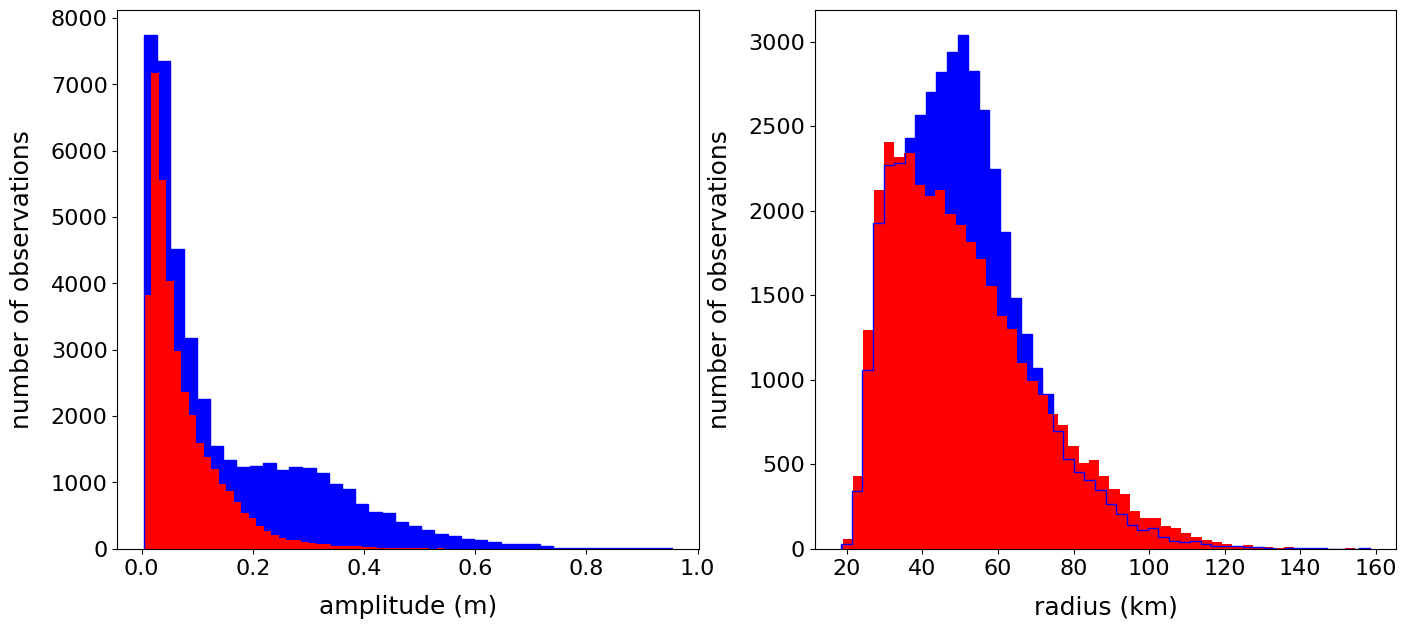

In [11]:
nbdays = 7

label_size = 18
tick_size  = 16

# Amplitude and radius histogram
fig = plt.figure(figsize=(16.5, 7))

# -- amplitude
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('amplitude (m)', size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of observations',  size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

a_ampl = select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).amplitude
c_ampl = select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).amplitude

a_counts, a_bins = np.histogram(a_ampl, bins=40)
c_counts, c_bins = np.histogram(c_ampl, bins=40)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

# -- radius
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('radius (km)', size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of observations', size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

a_radius = select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).speed_radius * 1e-3
c_radius = select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).speed_radius * 1e-3

a_counts, a_bins = np.histogram(a_radius, bins=50)
c_counts, c_bins = np.histogram(c_radius, bins=50)

ax.stairs(c_counts, c_bins, color='blue', fill=True)
ax.stairs(a_counts, a_bins, color='red',  fill=True)
ax.stairs(c_counts, c_bins, color='blue', fill=False)

nb_ac = len(np.unique(select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).tracks))
nb_ce = len(np.unique(select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).tracks))

nb_ac_obs = len(select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=nbdays).time)
nb_ce_obs = len(select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=nbdays).time)

print("Cyclonic eddies in the South East Agulhas Current (SEAC) region from {} to {}".format(*time_period))
print("  > With lifetime >= {} days: {} on {} observations".format(nbdays, nb_ce, nb_ce_obs))
print("  > Mean amplitude = {:.3f} ".format(c_ampl.mean()))
print("  > Mean radius    = {:.1f} ".format(c_radius.mean()))
print()
print("Anticyclonic eddies in the South East Agulhas Current (SEAC) region from {} to {}".format(*time_period))
print("  > With lifetime >= {} days: {} on {} observations".format(nbdays, nb_ac, nb_ac_obs))
print("  > Mean amplitude = {:.3f} ".format(a_ampl.mean()))
print("  > Mean radius    = {:.1f} ".format(a_radius.mean()))
print()

In [12]:
fig.savefig('../../imgs/OTC23_eddies_amplitude_radius_frequency_lt{}.png'.format(nbdays), dpi=300)

In [13]:
# Count and sort C/A eddy tracks by lifetime
eddy_lifetimes = np.concatenate( ([1], np.arange(7, 211, 7)) )
c_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
a_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
ca_ratio_count = np.ones_like(eddy_lifetimes)*np.nan

ac_eddies, ac_lifetime = np.unique(select_tracks_in_box(a_obs_seac, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)
ce_eddies, ce_lifetime = np.unique(select_tracks_in_box(c_obs_seac, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)

for i, days in enumerate(eddy_lifetimes):
    if (ce_lifetime > days).sum() != 0:
        c_eddies_count[i] = (ce_lifetime > days).sum()
    if (ac_lifetime > days).sum() != 0:
        a_eddies_count[i] = (ac_lifetime > days).sum()
        ca_ratio_count[i] = c_eddies_count[i]/a_eddies_count[i]

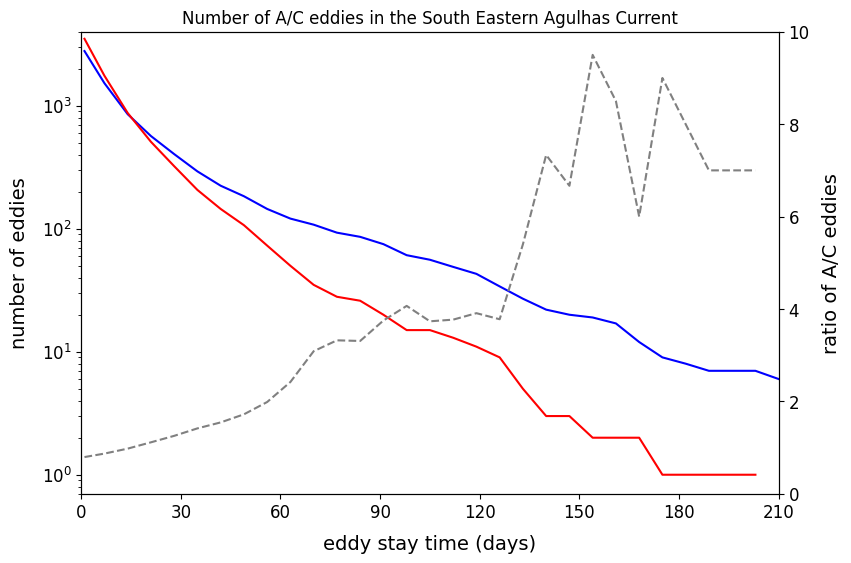

In [14]:
label_size = 14
tick_size  = 12

# Plot C/A eddy tracks repartition by lifetimes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Number of A/C eddies in the South Eastern Agulhas Current')
ax.set_xlabel('eddy stay time (days)',  size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of eddies',       size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

ax.set_yscale('log')
ax.set_xlim(0, 210)
ax.set_xticks(np.arange(0, 211, 30))
ax.set_ylim(0.7, 4000)
ax.plot(eddy_lifetimes, c_eddies_count, c='blue',  label='Cyclonic')
ax.plot(eddy_lifetimes, a_eddies_count, c='red',   label='Anticyclonic')

ax2 = ax.twinx()
ax2.set_ylim(0, 10)
ax2.set_yticks(list(np.arange(0, 11, 2)))
ax2.set_ylabel('ratio of A/C eddies',  size=label_size, labelpad=int(label_size*2/3))
ax2.tick_params(labelsize=tick_size)

ax2.plot(eddy_lifetimes, ca_ratio_count, c='grey', linestyle='dashed', label='Ration C/A')

In [15]:
fig.savefig('../../imgs/OTC23_number_eddies_SEAC_by_staytimes.png', dpi=300)

In [16]:
# Count and sort C/A eddy tracks by lifetime
eddy_lifetimes = np.concatenate( ([1], np.arange(7, 211, 7)) )
c_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
a_eddies_count = np.ones_like(eddy_lifetimes)*np.nan
ca_ratio_count = np.ones_like(eddy_lifetimes)*np.nan

ac_eddies, ac_lifetime = np.unique(select_tracks_in_box(a_eddies, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)
ce_eddies, ce_lifetime = np.unique(select_tracks_in_box(c_eddies, box_south_agulhas, min_lifetime=1).tracks, 
                                   return_counts=True)

for i, days in enumerate(eddy_lifetimes):
    if (ce_lifetime > days).sum() != 0:
        c_eddies_count[i] = (ce_lifetime > days).sum()
    if (ac_lifetime > days).sum() != 0:
        a_eddies_count[i] = (ac_lifetime > days).sum()
        ca_ratio_count[i] = c_eddies_count[i]/a_eddies_count[i]

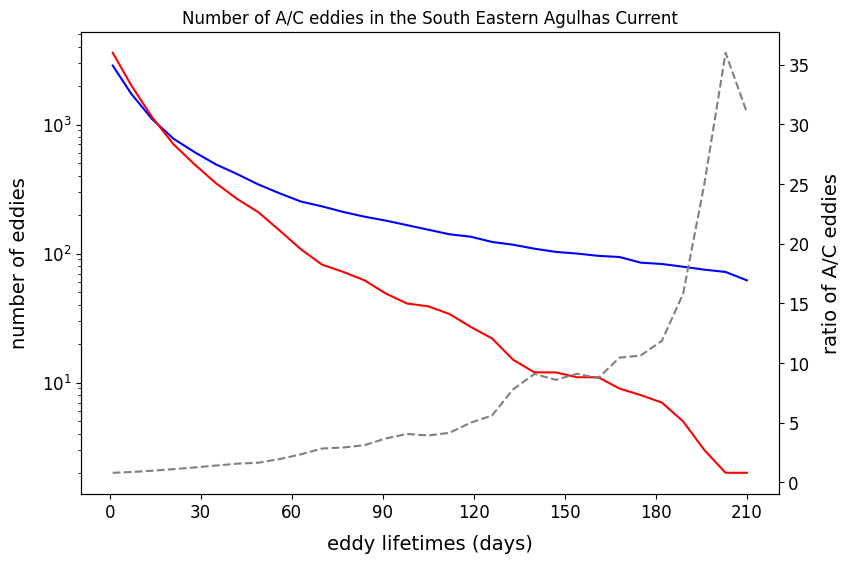

In [17]:
label_size = 14
tick_size  = 12

# Plot C/A eddy tracks repartition by lifetimes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Number of A/C eddies in the South Eastern Agulhas Current')
ax.set_xlabel('eddy lifetimes (days)', size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel('number of eddies',       size=label_size, labelpad=int(label_size*2/3))
ax.tick_params(labelsize=tick_size)

ax.set_yscale('log')
ax.set_xticks(np.arange(0, 211, 30))
ax.plot(eddy_lifetimes, c_eddies_count, c='blue',  label='Cyclonic')
ax.plot(eddy_lifetimes, a_eddies_count, c='red',   label='Anticyclonic')

ax2 = ax.twinx()
ax2.set_ylabel('ratio of A/C eddies',  size=label_size, labelpad=int(label_size*2/3))
ax2.tick_params(labelsize=tick_size)

ax2.plot(eddy_lifetimes, ca_ratio_count, c='grey', linestyle='dashed', label='Ration C/A')

In [18]:
fig.savefig('../../imgs/OTC23_number_eddies_by_lifetimes.png', dpi=300)

### Generation/dissipation sites of SEAC eddies

In [19]:
lon_min_semc, lon_max_semc = box_semc['longitude']
lat_min_semc, lat_max_semc = box_semc['latitude']

In [20]:
c_eddies_sac  = select_tracks_in_box(c_eddies, box_south_agulhas, min_lifetime=7)
ids_south_ac  = np.unique(c_eddies_sac.tracks)

c_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
c_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_c in ids_south_ac:
    track = c_eddies_sac.extract_ids([id_c])
    
    # check generation sites
    if (lon_min_seac <= track.lon[0] <= lon_max_seac) and (lat_min_seac <= track.lat[0] <= lat_max_seac):
        c_formations['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        c_formations['semc'].append(id_c)
    
    elif (-43 <= track.lat[0] <= lat_min_seac):
        c_formations['retroflection'].append(id_c)
    
    # check dissipation sites
    if (lon_min_seac <= track.lon[-1] <= lon_max_seac) and (lat_min_seac <= track.lat[-1] <= lat_max_seac):
        c_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        c_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_seac):
        c_dissipation['retroflection'].append(id_c)


# Print generation/dissipation sites
print("Cyclonic eddies observed in the southern Agulhas Current region from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ac), len(c_eddies_sac.amplitude)))

nb_sac   = len(c_formations['south_ac'])
nb_semc  = len(c_formations['semc'])
nb_retro = len(c_formations['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

nb_sac   = len(c_dissipation['south_ac'])
nb_semc  = len(c_dissipation['semc'])
nb_retro = len(c_dissipation['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

Cyclonic eddies observed in the southern Agulhas Current region from 2003-01-01 to 2022-12-31
  > Total: 1858 tracks on 72435 observations
  > generation sites:
       South-East Agulhas Current   : 1373 (73.9%)
       South-East Madagascar Current: 44 (2.4%)
       Agulhas retroflection area   : 109 (5.9%)
       Other areas                  : 332 (17.9%)
  > dissipation sites:
       South-East Agulhas Current   : 1586 (85.4%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 99 (5.3%)
       Other areas                  : 173 (9.3%)


In [21]:
a_eddies_sac  = select_tracks_in_box(a_eddies, box_south_agulhas, min_lifetime=7)
ids_south_ac  = np.unique(a_eddies_sac.tracks)

a_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
a_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_a in ids_south_ac:
    track = a_eddies_sac.extract_ids([id_a])
    
    # check generation sites
    if (lon_min_seac <= track.lon[0] <= lon_max_seac) and (lat_min_seac <= track.lat[0] <= lat_max_seac):
        a_formations['south_ac'].append(id_a)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        a_formations['semc'].append(id_a)
    
    elif (-43 <= track.lat[0] <= lat_min_seac):
        a_formations['retroflection'].append(id_a)
        
    # check dissipation sites
    if (lon_min_seac <= track.lon[-1] <= lon_max_seac) and (lat_min_seac <= track.lat[-1] <= lat_max_seac):
        a_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        a_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_seac):
        a_dissipation['retroflection'].append(id_c)

    
# Print generation/dissipation sites
print("Anticyclonic eddies observed in the southern Agulhas Current region from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ac), len(a_eddies_sac.amplitude)))

nb_sac   = len(a_formations['south_ac'])
nb_semc  = len(a_formations['semc'])
nb_retro = len(a_formations['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

nb_sac   = len(a_dissipation['south_ac'])
nb_semc  = len(a_dissipation['semc'])
nb_retro = len(a_dissipation['retroflection'])
nb_other = len(ids_south_ac) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ac)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ac)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ac)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ac)) )

Anticyclonic eddies observed in the southern Agulhas Current region from 2003-01-01 to 2022-12-31
  > Total: 2210 tracks on 50577 observations
  > generation sites:
       South-East Agulhas Current   : 1833 (82.9%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 102 (4.6%)
       Other areas                  : 275 (12.4%)
  > dissipation sites:
       South-East Agulhas Current   : 1910 (86.4%)
       South-East Madagascar Current: 0 (0.0%)
       Agulhas retroflection area   : 164 (7.4%)
       Other areas                  : 136 (6.2%)


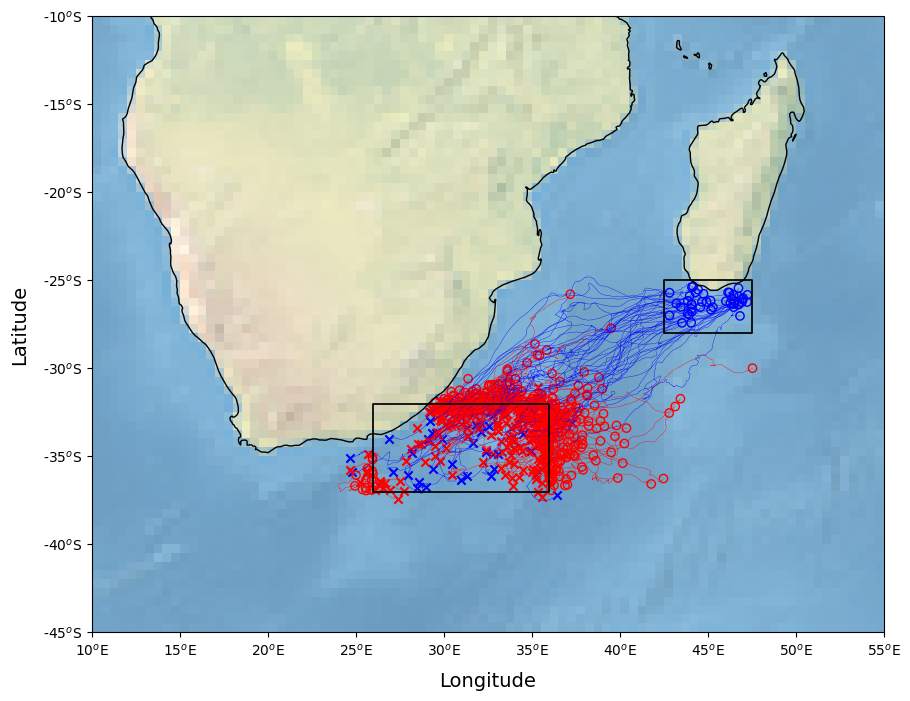

In [22]:
# Example visualize generation/dissipation sites of C eddies generated in SEMC + A eddies generated elsewhere
# -- set `plot_track` to True to plot the track of each eddy
plot_c_track, plot_a_track = True, True

gen_clons, gen_alons = list(), list()
gen_clats, gen_alats = list(), list()
dis_clons, dis_alons = list(), list()
dis_clats, dis_alats = list(), list()


# Plot generation/dissipation sites
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

ax.set_xlabel(r"Longitude", size=14, labelpad=10)
ax.set_ylabel(r"Latitude",  size=14, labelpad=10)

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
yticks = [-45, -40, -35, -30, -25, -20, -15, -10]
ax.set_xticks(xticks)
ax.set_xticklabels(['{}$^o$E'.format(x) for x in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels(['{}$^o$S'.format(y) for y in yticks])

# -- add eddy tracks
if plot_c_track:
    for ide in c_formations['semc']:
        track = c_eddies_sac.extract_ids([ide])
        track.plot(ax, color="blue", lw=0.25)

        gen_clons.append(track.lon[0])
        gen_clats.append(track.lat[0])
        dis_clons.append(track.lon[-1])
        dis_clats.append(track.lat[-1])

if plot_a_track:
    for ide in np.unique(a_eddies_sac.tracks):
        if ide not in a_formations['south_ac'] + a_formations['semc'] + a_formations['retroflection']:
            track = a_eddies_sac.extract_ids([ide])
            track.plot(ax, color="red", lw=0.25)

            gen_alons.append(track.lon[0])
            gen_alats.append(track.lat[0])
            dis_alons.append(track.lon[-1])
            dis_alats.append(track.lat[-1])
        
# -- add eddy generation sites
ax.scatter(gen_clons, gen_clats, marker='o', facecolor='none', edgecolors='blue')
ax.scatter(dis_clons, dis_clats, marker='x', facecolor='blue')

ax.scatter(gen_alons, gen_alats, marker='o', facecolor='none', edgecolors='red')
ax.scatter(dis_alons, dis_alats, marker='x', facecolor='red')

# -- add contour box
geom_agulhas = linear_ring_from_box(box_south_agulhas)
geom_semc    = linear_ring_from_box(box_semc)

ax.add_geometries([geom_agulhas, geom_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', lw=1.25, 
                  zorder=100)

plt.show()

In [23]:
fig.savefig('../../imgs/OTC23_eddy_tracks_from_SEMC.png', dpi=300)

### Generation/dissipation sites of SEMC eddies

In [24]:
c_eddies_semc  = select_tracks_in_box(c_eddies, box_semc, min_lifetime=7)
ids_south_ma   = np.unique(c_eddies_semc.tracks)

c_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
c_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_c in ids_south_ma:
    track = c_eddies_semc.extract_ids([id_c])
    
    # check generation sites
    if (lon_min_seac <= track.lon[0] <= lon_max_seac) and (lat_min_seac <= track.lat[0] <= lat_max_seac):
        c_formations['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        c_formations['semc'].append(id_c)
    
    elif (-43 <= track.lat[0] <= lat_min_seac):
        c_formations['retroflection'].append(id_c)
    
    # check dissipation sites
    if (lon_min_seac <= track.lon[-1] <= lon_max_seac) and (lat_min_seac <= track.lat[-1] <= lat_max_seac):
        c_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        c_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_seac):
        c_dissipation['retroflection'].append(id_c)


# Print generation/dissipation sites
print("Cyclonic eddies observed in the South Madagascar area from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ma), len(c_eddies_semc.amplitude)))

nb_sac   = len(c_formations['south_ac'])
nb_semc  = len(c_formations['semc'])
nb_retro = len(c_formations['retroflection'])
nb_other = len(ids_south_ma) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ma)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ma)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ma)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ma)) )

nb_sac   = len(c_dissipation['south_ac'])
nb_semc  = len(c_dissipation['semc'])
nb_retro = len(c_dissipation['retroflection'])
nb_other = len(ids_south_ma) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ma)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ma)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ma)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ma)) )

Cyclonic eddies observed in the South Madagascar area from 2003-01-01 to 2022-12-31
  > Total: 818 tracks on 41477 observations
  > generation sites:
       South-East Agulhas Current   : 0 (0.0%)
       South-East Madagascar Current: 657 (80.3%)
       Agulhas retroflection area   : 0 (0.0%)
       Other areas                  : 161 (19.7%)
  > dissipation sites:
       South-East Agulhas Current   : 41 (5.0%)
       South-East Madagascar Current: 520 (63.6%)
       Agulhas retroflection area   : 3 (0.4%)
       Other areas                  : 254 (31.1%)


In [25]:
a_eddies_semc  = select_tracks_in_box(a_eddies, box_semc, min_lifetime=7)
ids_south_ma   = np.unique(a_eddies_semc.tracks)

a_formations  = {'south_ac': list(), 'semc': list(), 'retroflection': list()}
a_dissipation = {'south_ac': list(), 'semc': list(), 'retroflection': list()}

for id_a in ids_south_ma:
    track = a_eddies_semc.extract_ids([id_a])
    
    # check generation sites
    if (lon_min_seac <= track.lon[0] <= lon_max_seac) and (lat_min_seac <= track.lat[0] <= lat_max_seac):
        a_formations['south_ac'].append(id_a)
    
    elif (lon_min_semc <= track.lon[0] <= lon_max_semc) and (lat_min_semc <= track.lat[0] <= lat_max_semc):
        a_formations['semc'].append(id_a)
    
    elif (-43 <= track.lat[0] <= lat_min_seac):
        a_formations['retroflection'].append(id_a)
        
    # check dissipation sites
    if (lon_min_seac <= track.lon[-1] <= lon_max_seac) and (lat_min_seac <= track.lat[-1] <= lat_max_seac):
        a_dissipation['south_ac'].append(id_c)
    
    elif (lon_min_semc <= track.lon[-1] <= lon_max_semc) and (lat_min_semc <= track.lat[-1] <= lat_max_semc):
        a_dissipation['semc'].append(id_c)
    
    elif (-43 <= track.lat[-1] <= lat_min_seac):
        a_dissipation['retroflection'].append(id_c)

    
# Print generation/dissipation sites
print("Anticyclonic eddies observed in the South Madagascar area from {} to {}".format(*time_period))
print("  > Total: {} tracks on {} observations".format(len(ids_south_ma), len(a_eddies_semc.amplitude)))

nb_sac   = len(a_formations['south_ac'])
nb_semc  = len(a_formations['semc'])
nb_retro = len(a_formations['retroflection'])
nb_other = len(ids_south_ma) - nb_sac - nb_semc - nb_retro

print("  > generation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ma)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ma)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ma)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ma)) )

nb_sac   = len(a_dissipation['south_ac'])
nb_semc  = len(a_dissipation['semc'])
nb_retro = len(a_dissipation['retroflection'])
nb_other = len(ids_south_ma) - nb_sac - nb_semc - nb_retro

print("  > dissipation sites:")
print("       South-East Agulhas Current   : {} ({:.1f}%)".format(nb_sac, 100*nb_sac/len(ids_south_ma)) )
print("       South-East Madagascar Current: {} ({:.1f}%)".format(nb_semc, 100*nb_semc/len(ids_south_ma)) )
print("       Agulhas retroflection area   : {} ({:.1f}%)".format(nb_retro, 100*nb_retro/len(ids_south_ma)) )
print("       Other areas                  : {} ({:.1f}%)".format(nb_other, 100*nb_other/len(ids_south_ma)) )

Anticyclonic eddies observed in the South Madagascar area from 2003-01-01 to 2022-12-31
  > Total: 883 tracks on 19319 observations
  > generation sites:
       South-East Agulhas Current   : 0 (0.0%)
       South-East Madagascar Current: 726 (82.2%)
       Agulhas retroflection area   : 0 (0.0%)
       Other areas                  : 157 (17.8%)
  > dissipation sites:
       South-East Agulhas Current   : 0 (0.0%)
       South-East Madagascar Current: 612 (69.3%)
       Agulhas retroflection area   : 0 (0.0%)
       Other areas                  : 271 (30.7%)


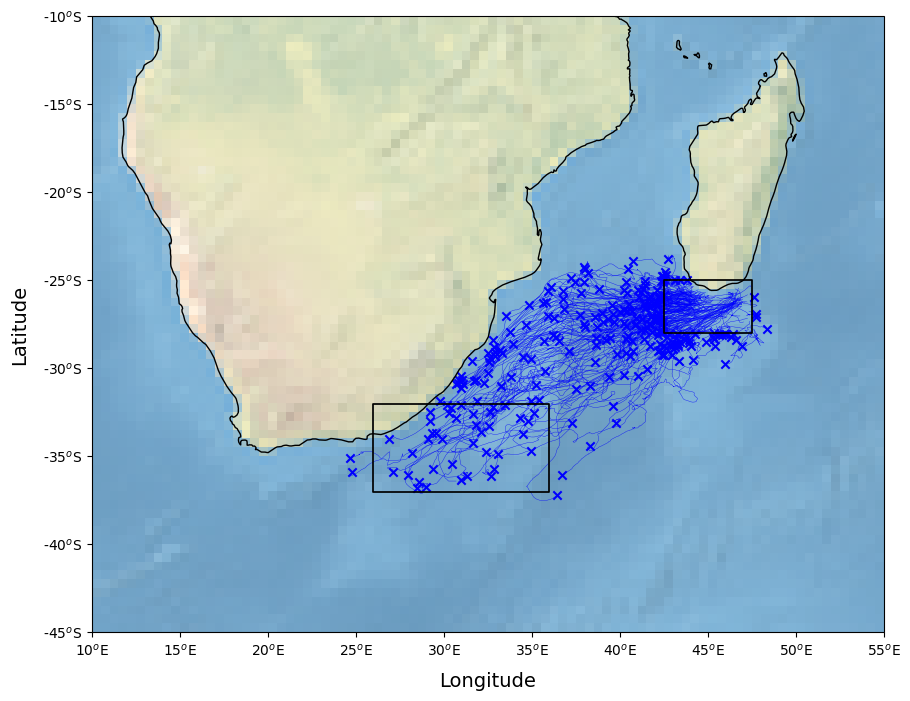

In [26]:
# Example visualize generation/dissipation sites of C eddies generated in SEMC + A eddies generated elsewhere
# -- set `plot_track` to True to plot the track of each eddy
plot_c_track, plot_a_track = True, False

gen_clons, gen_alons = list(), list()
gen_clats, gen_alats = list(), list()
dis_clons, dis_alons = list(), list()
dis_clats, dis_alats = list(), list()


# Plot generation/dissipation sites
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

ax.set_xlabel(r"Longitude", size=14, labelpad=10)
ax.set_ylabel(r"Latitude",  size=14, labelpad=10)

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
yticks = [-45, -40, -35, -30, -25, -20, -15, -10]
ax.set_xticks(xticks)
ax.set_xticklabels(['{}$^o$E'.format(x) for x in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels(['{}$^o$S'.format(y) for y in yticks])

# -- add eddy tracks
if plot_c_track:
    for ide in np.unique(c_formations['semc']):
        if ide not in c_dissipation['semc']:
            track = c_eddies_semc.extract_ids([ide])
            track.plot(ax, color="blue", lw=0.25)

            gen_clons.append(track.lon[0])
            gen_clats.append(track.lat[0])
            dis_clons.append(track.lon[-1])
            dis_clats.append(track.lat[-1])

if plot_a_track:
    for ide in np.unique(a_eddies_semc.tracks):
        if ide not in a_dissipation['semc']:
            track = a_eddies_semc.extract_ids([ide])
            track.plot(ax, color="red", lw=0.25)

            gen_alons.append(track.lon[0])
            gen_alats.append(track.lat[0])
            dis_alons.append(track.lon[-1])
            dis_alats.append(track.lat[-1])
        
# -- add eddy generation sites
#ax.scatter(gen_clons, gen_clats, marker='o', facecolor='none', edgecolors='blue')
ax.scatter(dis_clons, dis_clats, marker='x', facecolor='blue')

ax.scatter(gen_alons, gen_alats, marker='o', facecolor='none', edgecolors='red')
ax.scatter(dis_alons, dis_alats, marker='x', facecolor='red')

# -- add contour box
geom_agulhas = linear_ring_from_box(box_south_agulhas)
geom_semc    = linear_ring_from_box(box_semc)

ax.add_geometries([geom_agulhas, geom_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', lw=1.25, 
                  zorder=100)

plt.show()

Text(0.78, 0.4, '-0.027 $\\degree$/day')

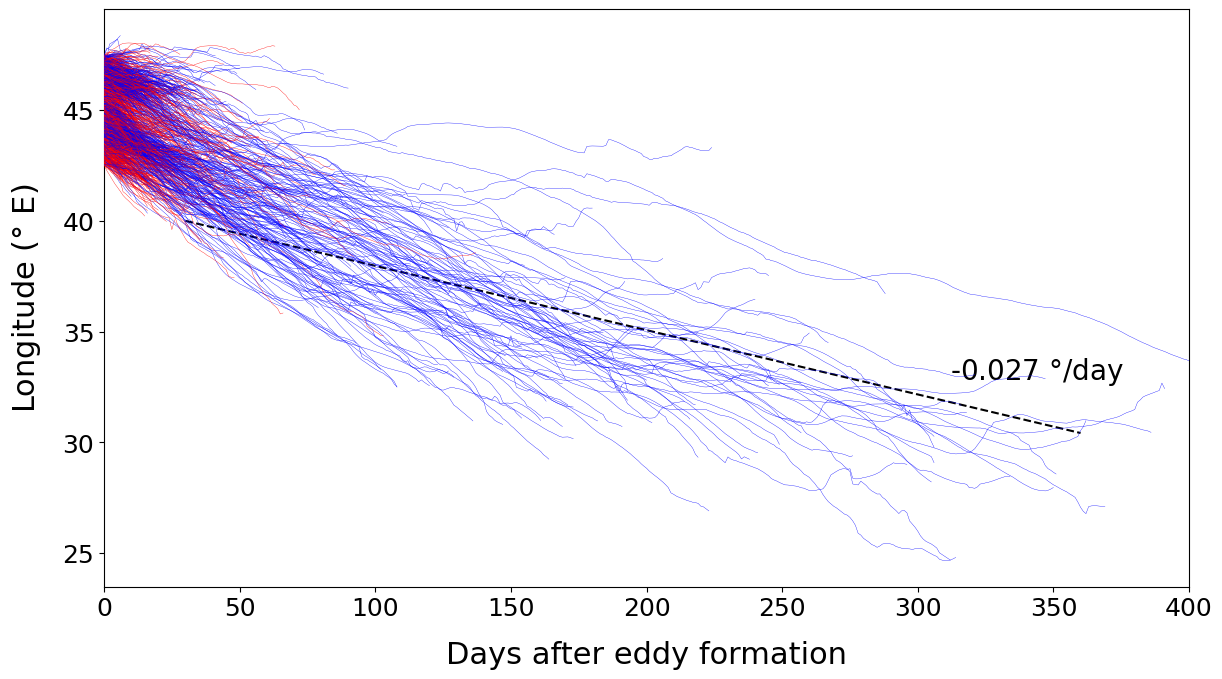

In [27]:
# Plot
fig = plt.figure(figsize=(14, 7.5))

xlons = np.arange(25, 47, 1)
ccnts = np.zeros_like(xlons)
acnts = np.zeros_like(xlons)

# -- ax
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Days after eddy formation', size=22, labelpad=14)
ax.set_ylabel('Longitude ($\degree$ E)', size=22, labelpad=14)
ax.tick_params(labelsize=18)

ax.set_xlim(0, 400)

nb_eddies_tot = len(c_formations['semc']) + len(a_formations['semc'])
eddy_order    = np.random.default_rng().choice(nb_eddies_tot, size=nb_eddies_tot, replace=False)

for i, ide in enumerate(c_formations['semc']):
    track = c_eddies_semc.extract_ids([ide])
    ccnts += xlons > track.lon.min()
    
    zo    = eddy_order[i]
    ax.plot(track.time - track.time[0], track.lon, color='blue', lw=0.25, zorder=zo)
    
for i, ide in enumerate(a_formations['semc']):
    track = a_eddies_semc.extract_ids([ide])
    acnts += xlons > track.lon.min()
    
    zo    = eddy_order[i+len(c_formations['semc'])]
    ax.plot(track.time - track.time[0], track.lon, color='red', lw=0.25, zorder=zo)


ax.plot([30, 360], [40, 40-360*0.0266], 'k--')
ax.text(0.78, 0.4, "{:.3f} $\degree$/day".format(-0.0266), fontsize=20, c='black',
                    transform=ax.transAxes, verticalalignment='top')

In [28]:
fig.savefig('../../imgs/OTC23_eddy_drift_with_wave_trends.png', dpi=300)

/tmp/ipykernel_10260/3598192375.py:51: RuntimeWarning: Mean of empty slice
  ax.plot(xlons, 1e-3*np.nanmean(arads, axis=-1), 'red')
/tmp/ipykernel_10260/3598192375.py:52: RuntimeWarning: Mean of empty slice
  ax.scatter(xlons, 1e-3*np.nanmean(arads, axis=-1), s=50, c='red', marker='o')


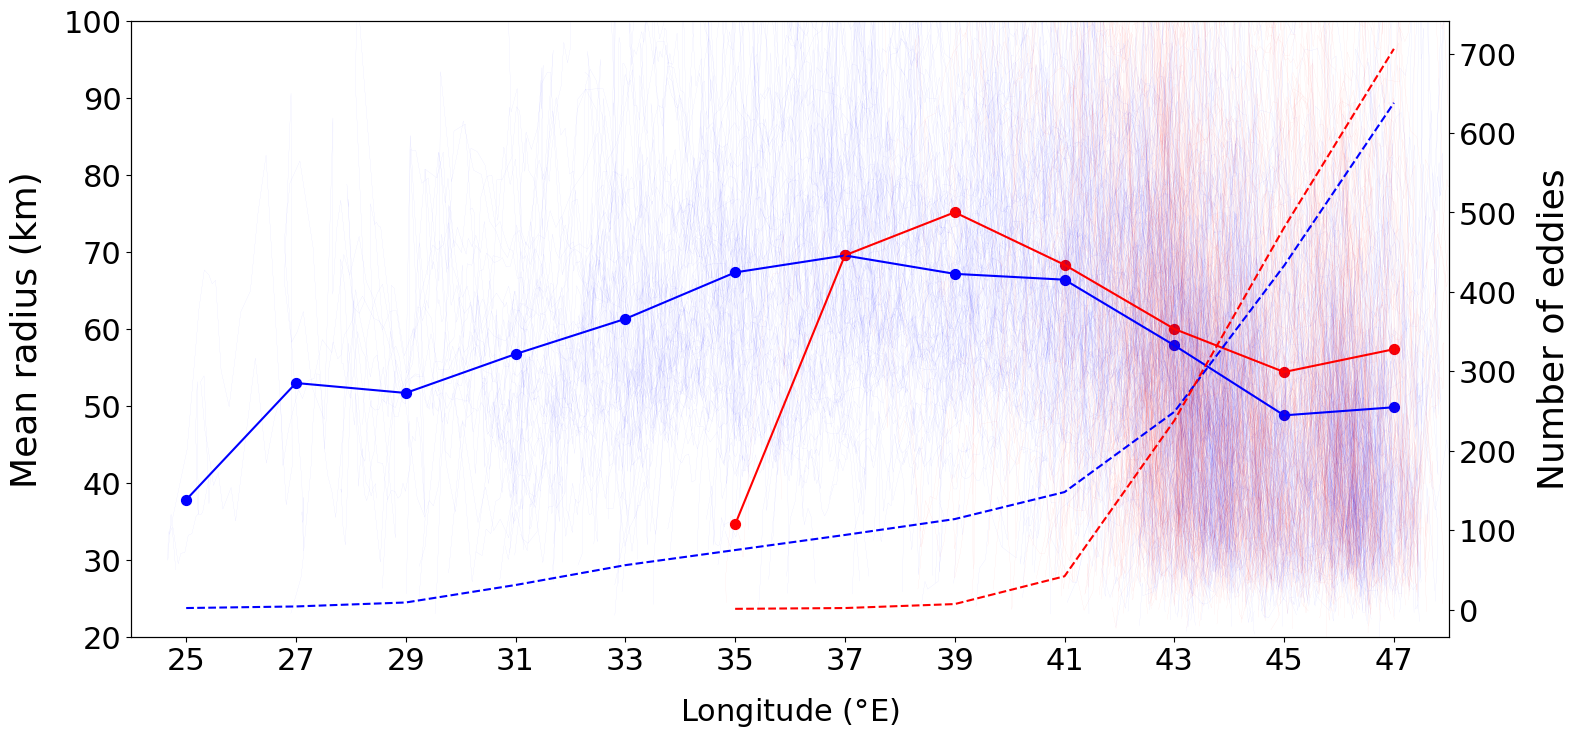

In [31]:
# Plot
fig = plt.figure(figsize=(17, 8.5))

xlons = np.arange(25, 48, 2)
ccnts = np.zeros_like(xlons)
acnts = np.zeros_like(xlons)
crads = np.zeros( (len(xlons), len(c_formations['semc'])) )
arads = np.zeros( (len(xlons), len(a_formations['semc'])) )

# -- ax
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Longitude ($\degree$E)', size=22, labelpad=14)
ax.set_ylabel('Mean radius (km)', size=26, labelpad=14)
ax.set_ylim(20, 100)
ax.set_xlim(xlons[0]-1, xlons[-1]+1)
ax.set_xticks(xlons)
ax.tick_params(labelsize=22)

ax2 = ax.twinx()
ax2.set_ylabel('Number of eddies', size=26, labelpad=14)
ax2.tick_params(labelsize=22)

for i, ide in enumerate(c_formations['semc']):
    track = c_eddies_semc.extract_ids([ide])
    ccnts += xlons > track.lon.min()
    
    sinds = np.argsort(track.lon)
    tlons = track.lon[sinds]
    trads = track.speed_radius[sinds]
    
    crads[:,i] = np.interp(xlons, tlons, trads, left=np.nan, right=np.nan)
    
    ax.plot(track.lon, 1e-3*track.speed_radius, color=(0,0,1, 0.2), lw=0.1)
    
for i, ide in enumerate(a_formations['semc']):
    track = a_eddies_semc.extract_ids([ide])
    acnts += xlons > track.lon.min()
    
    sinds = np.argsort(track.lon)
    tlons = track.lon[sinds]
    trads = track.speed_radius[sinds]
    
    arads[:,i] = np.interp(xlons, tlons, trads, left=np.nan, right=np.nan)
    
    ax.plot(track.lon, 1e-3*track.speed_radius, color=(1,0,0, 0.2), lw=0.1)
    
# add radius mean
ax.plot(xlons, 1e-3*np.nanmean(crads, axis=-1), 'blue')
ax.scatter(xlons, 1e-3*np.nanmean(crads, axis=-1), s=50, c='blue', marker='o')

ax.plot(xlons, 1e-3*np.nanmean(arads, axis=-1), 'red')
ax.scatter(xlons, 1e-3*np.nanmean(arads, axis=-1), s=50, c='red', marker='o')

# add count
ccnts = np.where(ccnts==0, np.nan, ccnts)
acnts = np.where(acnts==0, np.nan, acnts)

ax2.plot(xlons, ccnts, 'blue', ls='dashed')
ax2.plot(xlons, acnts, 'red',  ls='dashed')

In [32]:
fig.savefig('../../imgs/OTC23_eddy_drift_radius.png', dpi=300)

### dipole occurences

__warning__: code not efficient, could be improved

In [ ]:
# Init dictionnary counter
dipole_observations = dict()

In [ ]:
# Dipole detection algorithm following (Ni et al. 2020)
for t_int in np.unique(c_eddies_sac.time):
    cyclonic     = c_eddies_sac.extract_with_period( (t_int, t_int) )
    anticyclonic = a_eddies_sac.extract_with_period( (t_int, t_int) )

    c_len        = len(cyclonic.amplitude)
    a_len        = len(anticyclonic.amplitude)

    # compute distance matrix between cyclonic and anticyclonic eddies
    x_cyc        = np.stack([get_xcoord(cyclonic.lon, cyclonic.lat)]*a_len, axis=-1)
    y_cyc        = np.stack([get_ycoord(cyclonic.lon, cyclonic.lat)]*a_len, axis=-1)
    x_ant        = np.stack([get_xcoord(anticyclonic.lon, anticyclonic.lat)]*c_len, axis=0)
    y_ant        = np.stack([get_ycoord(anticyclonic.lon, anticyclonic.lat)]*c_len, axis=0)

    distance     = ((x_cyc-x_ant)**2 + (y_cyc-y_ant)**2)**0.5

    # criterion 1: dist(centers) < sum(radius)
    r_cyc        = np.stack([cyclonic.effective_radius]*a_len, axis=-1)
    r_ant        = np.stack([anticyclonic.effective_radius]*c_len, axis=0)
    r_sum        = r_cyc + r_ant

    # save dipole candidates
    indexes_dist = np.where(distance < r_sum)

    for j, ic in enumerate(indexes_dist[0]):
        track_cyc = cyclonic.tracks[ic]
        track_ant = anticyclonic.tracks[indexes_dist[1][j]]
        
        # criterion 2: take only amplitude > 10cm
        amp_cyc   = cyclonic.amplitude[ic]
        amp_ant   = anticyclonic.amplitude[indexes_dist[1][j]]
        if amp_cyc < 0.1 or amp_ant < 0.1:
            continue

        lon_cyc   = cyclonic.lon[ic]
        lat_cyc   = cyclonic.lat[ic]

        lon_ant   = anticyclonic.lon[indexes_dist[1][j]]
        lat_ant   = anticyclonic.lat[indexes_dist[1][j]]

        # criterion 3: one local extremum of velocity between the 2 eddy centers
        lon_path  = np.linspace(lon_cyc, lon_ant, 100)
        lat_path  = np.linspace(lat_cyc, lat_ant, 100)

        ids = ds.sel({'time': to_datetime(t_int)})
        vals = list()
        for i in range(100):
            currents = (ids['ugos']**2 + ids['vgos']**2)**0.5
            val      = float(currents.interp(longitude=lon_path[i], latitude=lat_path[i]))
            vals.append(val)

        maximums = argrelextrema(np.array(vals), np.greater)[0]

        # add dipole if only one extremum
        if len(maximums) == 1:
            dipole    = dipole_observations.setdefault( (track_cyc, track_ant), {'time' : []})
            if t_int not in dipole['time']:
                dipole['time'].append(t_int)

In [ ]:
# Add a dipole strength as a mean between cyclonic and anticyclonic amplitudes
for d in dipole_observations:
    e_time = dipole_observations[d]['time']
    c_eddy = c_eddies_sac.extract_ids([d[0]])
    a_eddy = a_eddies_sac.extract_ids([d[1]])
    
    c_ampl = c_eddy.extract_with_period( (e_time[0], e_time[-1]) ).amplitude
    a_ampl = a_eddy.extract_with_period( (e_time[0], e_time[-1]) ).amplitude
    
    c_elon = c_eddy.extract_with_period( (e_time[0], e_time[-1]) ).lon
    a_elon = a_eddy.extract_with_period( (e_time[0], e_time[-1]) ).lon
    
    c_elat = c_eddy.extract_with_period( (e_time[0], e_time[-1]) ).lat
    a_elat = a_eddy.extract_with_period( (e_time[0], e_time[-1]) ).lat
    
    d_ampl = (c_ampl + a_ampl)/2.
    dipole_observations[d]['strength'] = d_ampl
    
    dipole_observations[d]['lon']      = (c_elon + a_elon)/2
    dipole_observations[d]['lat']      = (c_elat + a_elat)/2

In [ ]:
# select only observations in SEAC box
dipoles = dict(dipole_observations)
for d in dipoles:
    conds = (dipoles[d]['lon'] > lon_max_seac) & (dipoles[d]['lon'] < lon_min_seac)
    conds = conds & (dipoles[d]['lat'] > lat_max_seac) & (dipoles[d]['lat'] < lat_min_seac)
    ind2r = np.where(conds)
    
    for k in dipoles[d]:
        dipoles[d][k] = np.delete(dipoles[d][k], ind2r)

In [ ]:
# Dipole counts + dipole strength histogram
dipole_counts   = [d for d in dipoles if len(dipoles[d]['time']) > 6]
dipole_strenght = [dipoles[d]['strength'] for d in dipole_counts]
dipole_ampl_max = [np.max(dipoles[d]['strength']) for d in dipole_counts]

tot_eddy_counts = len(a_eddies_sac.amplitude) + len(c_eddies_sac.amplitude)
print("Eddy dipoles observed in the southern Agulhas Current region from {} to {}".format(*time_period))
print("  > Total: {} dipoles on {} observations".format(len(dipole_counts), tot_eddy_counts) )

In [ ]:
# Plot
fig = plt.figure(figsize=(16, 5))

# -- amplitude
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('mean dipole amplitude (m)', size=14, labelpad=10)
ax.set_ylabel('number of observations',    size=14, labelpad=10)
ax.tick_params(labelsize=12)

d_ampl           = np.concatenate(dipole_strenght)
d_counts, d_bins = np.histogram(d_ampl, bins=40)

ax.stairs(d_counts, d_bins, color='green', fill=True)

In [ ]:
fig.savefig('../../imgs/OTC23_eddies_amplitude_radius_frequency.png', dpi=300)

In [ ]:
# Plot
fig = plt.figure(figsize=(16, 5))

# -- amplitude max
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('mean dipole amplitude max reached by the dipole (m)', size=14, labelpad=10)
ax.set_ylabel('number of observations',    size=14, labelpad=10)
ax.tick_params(labelsize=12)

d_ampl_max       = np.array(dipole_ampl_max)
d_counts, d_bins = np.histogram(d_ampl_max, bins=20)

ax.stairs(d_counts, d_bins, color='green', fill=True)